## Application Report Master Data Science - Winter Semester 2024/2025

### Importing the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

from scipy.stats import pearsonr

from scipy.stats import shapiro
from statsmodels.stats.weightstats import ztest
from scipy.stats import norm

In [2]:
df = pd.read_csv('passes.csv', sep=";")
print(df.to_string())

     game_id  passing_quote winner
0         11           72.0     No
1         11           91.0    Yes
2         12           82.0    Yes
3         12           86.0     No
4         13           82.0    Yes
5         13           79.0     No
6         14           79.0     No
7         14           77.0    Yes
8         15           85.0     No
9         15           77.0     No
10        16           87.0    Yes
11        16           75.0     No
12        17           88.0    Yes
13        17           78.0     No
14        18           74.0    Yes
15        18           77.0     No
16        19           87.0    Yes
17        19           78.0     No
18        21           86.0    Yes
19        21           81.0     No
20        22           77.0    Yes
21        22           73.0     No
22        23           78.0     No
23        23           77.0    Yes
24        24           65.0     No
25        24           76.0     No
26        25           69.0     No
27        25        

### Pre-processing 

In [3]:
df.dropna(axis=0, inplace = True)
df['winner'] = df['winner'].map({'Yes': 1, 'No': 0})

In [4]:
game_id_list_1 = []
passing_quote_list_1 = []
winner_list_1 = []
points_1 = []
game_id_list_2 = []
passing_quote_list_2 = []
winner_list_2 = []
points_2 = []
game_id_list_3 = []
passing_quote_list_3 = []
winner_list_3 = []
points_3 = []

for i in range(len(df)):
    if i < len(df) - 1 and df['game_id'].iloc[i] == df['game_id'].iloc[i + 1] and df['winner'].iloc[i] == df['winner'].iloc[i + 1]:
        game_id_list_3.extend([df['game_id'].iloc[i], df['game_id'].iloc[i + 1]])
        passing_quote_list_3.extend([df['passing_quote'].iloc[i], df['passing_quote'].iloc[i + 1]])
        winner_list_3.extend([df['winner'].iloc[i], df['winner'].iloc[i + 1]])
        i += 1
    elif i < len(df) and df['winner'].iloc[i] == 0:
        game_id_list_2.append(df['game_id'].iloc[i])
        passing_quote_list_2.append(df['passing_quote'].iloc[i])
        winner_list_2.append(df['winner'].iloc[i])
    else: 
        game_id_list_1.append(df['game_id'].iloc[i])
        passing_quote_list_1.append(df['passing_quote'].iloc[i])
        winner_list_1.append(df['winner'].iloc[i])

df_winner = pd.DataFrame({
    'game_id': game_id_list_1,
    'passing_quote': passing_quote_list_1,
    'winner': winner_list_1
}).dropna()

df_winner['points'] = np.ones(len(df_winner), dtype=int)

df_loser = pd.DataFrame({
    'game_id': game_id_list_2,
    'passing_quote': passing_quote_list_2,
    'winner': winner_list_2
}).dropna()

df_loser['points'] = np.zeros(len(df_loser), dtype=int)

df_draw = pd.DataFrame({
    'game_id': game_id_list_3,
    'passing_quote': passing_quote_list_3,
    'winner': winner_list_3
}).dropna()

df_draw['points'] = np.full(len(df_draw), 0.5)

draw_list = list(df_draw['game_id'])
df_loser = df_loser[~df_loser['game_id'].isin(draw_list)]

game_data = pd.concat([df_winner, df_loser, df_draw], ignore_index = True, axis = 0)
game_data = game_data.sort_values(by='game_id').reset_index(drop=True)
print(game_data.to_string())

     game_id  passing_quote  winner  points
0         11           91.0       1     1.0
1         11           72.0       0     0.0
2         12           86.0       0     0.0
3         12           82.0       1     1.0
4         13           79.0       0     0.0
5         13           82.0       1     1.0
6         14           77.0       1     1.0
7         14           79.0       0     0.0
8         15           77.0       0     0.5
9         15           85.0       0     0.5
10        16           75.0       0     0.0
11        16           87.0       1     1.0
12        17           88.0       1     1.0
13        17           78.0       0     0.0
14        18           74.0       1     1.0
15        18           77.0       0     0.0
16        19           78.0       0     0.0
17        19           87.0       1     1.0
18        21           86.0       1     1.0
19        21           81.0       0     0.0
20        22           73.0       0     0.0
21        22           77.0     

In [5]:
game_data.to_csv('game_data.csv', index=False)
game_data.dtypes

game_id            int64
passing_quote    float64
winner             int64
points           float64
dtype: object

### Exploratory Data Analysis

In [6]:
print("Winners:")
print(f"Mean passing rate: {df_winner['passing_quote'].mean()}")
print(f"Median passing rate: {df_winner['passing_quote'].median()}")
print(f"Standard deviation: {df_winner['passing_quote'].std()}")
print("\nLosers:")
print(f"Mean passing rate: {df_loser['passing_quote'].mean()}")
print(f"Median passing rate: {df_loser['passing_quote'].median()}")
print(f"Standard deviation: {df_loser['passing_quote'].std()}")
print("\nDraw:")
print(f"Mean passing rate: {df_draw['passing_quote'].mean()}")
print(f"Median passing rate: {df_draw['passing_quote'].median()}")
print(f"Standard deviation: {df_draw['passing_quote'].std()}")

Winners:
Mean passing rate: 81.07894736842105
Median passing rate: 83.0
Standard deviation: 8.06406289574839

Losers:
Mean passing rate: 79.26315789473684
Median passing rate: 79.0
Standard deviation: 5.135427241067675

Draw:
Mean passing rate: 78.21052631578948
Median passing rate: 79.5
Standard deviation: 7.2504083369581025


In [7]:
print('The winning team with the lowest passing rate')
print(df_winner[df_winner.passing_quote == df_winner.passing_quote.min()])

print('\nThe winning team with the highest passing rate')
print(df_winner[df_winner.passing_quote == df_winner.passing_quote.max()])

print('\nThe losing team with the lowest passing rate')
print(df_loser[df_loser.passing_quote == df_loser.passing_quote.min()])

print('\nThe losing team with the highest passing rate')
print(df_loser[df_loser.passing_quote == df_loser.passing_quote.max()])

print('\nThe draw team with lowest passing rate')
print(df_draw[df_draw.passing_quote == df_draw.passing_quote.min()])

print('\nThe draw team with highest passing rate')
print(df_draw[df_draw.passing_quote == df_draw.passing_quote.max()])

The winning team with the lowest passing rate
    game_id  passing_quote  winner  points
96      152           53.0       1       1

The winning team with the highest passing rate
    game_id  passing_quote  winner  points
47       77           92.0       1       1
75      117           92.0       1       1

The losing team with the lowest passing rate
     game_id  passing_quote  winner  points
109      132           63.0       0       0

The losing team with the highest passing rate
     game_id  passing_quote  winner  points
118      143           90.0       0       0
133      159           90.0       0       0

The draw team with lowest passing rate
   game_id  passing_quote  winner  points
8       35           59.0       0     0.5

The draw team with highest passing rate
    game_id  passing_quote  winner  points
24       73           89.0       0     0.5


In [8]:
# Points Standard Deviation
print(np.std(game_data['points'], ddof=0))
# Passing Rate Standard Deviation
print(np.std(game_data['passing_quote'], ddof=0))

0.4330127018922193
6.948601085571029


#### Correlation Analysis

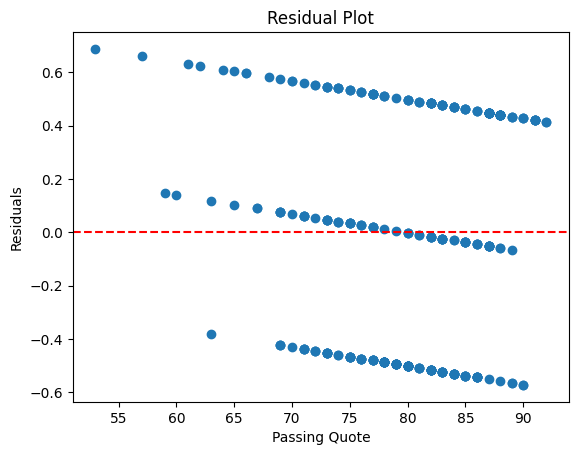

In [9]:
model = LinearRegression()
X = game_data[['passing_quote']]
y = game_data['points']
model.fit(X, y)

residuals = y - model.predict(X)
plt.scatter(X, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Passing Quote')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [10]:
print(np.corrcoef(game_data['passing_quote'], game_data['points']))

[[1.        0.1131537]
 [0.1131537 1.       ]]


In [11]:
from scipy.stats import pearsonr

pearson_corr, p_value = pearsonr(game_data['passing_quote'], game_data['points'])

print("Pearson Correlation Coefficient:", pearson_corr)
print("P-value:", p_value)

Pearson Correlation Coefficient: 0.1131536976126234
P-value: 0.04871136943273925


#### Hypothesis Testing - Performing Z-test

##### 1. Does the winner of a match have a higher passing rate than the loser?
###### Null Hypothesis (H0): There is no difference in the mean passing rate between winning teams and losing teams & teams that ended in draw.
###### Alternative Hypothesis (H1): The mean passing rate of winners is higher than that of losers. 

In [12]:
#Population Standard Deviations
winner_pass_std = np.std(df_winner['passing_quote'], ddof=0)
loser_pass_std = np.std(df_loser['passing_quote'], ddof=0)
draw_pass_std = np.std(df_draw['passing_quote'], ddof=0)
print(winner_pass_std, loser_pass_std, draw_pass_std)

8.028616293840498 5.112853825235683 7.2025503331763705


In [13]:
#Mean
winner_mean = df_winner['passing_quote'].mean()
loser_mean = df_loser['passing_quote'].mean()
draw_mean = df_draw['passing_quote'].mean()
print(winner_mean, loser_mean, draw_mean)

81.07894736842105 79.26315789473684 78.21052631578948


In [14]:
n_winners = len(df_winner)
n_losers = len(df_loser)
n_draw = len(df_draw)
print(n_winners, n_losers, n_draw)

114 114 76


In [15]:
# Calculate z-statistic and p-value for winners and losers
z_stat = (winner_mean - loser_mean) / np.sqrt((winner_pass_std**2 / n_winners) + (loser_pass_std**2 / n_losers))
p_val = norm.sf(abs(z_stat))
z_stat, p_val

(2.036826007073908, 0.020833740563383094)

##### 2. Is the expected difference in passing rate in games that end in a draw different from the expected difference in passing rate in games with a winner?
###### Null Hypothesis (H0): The expected difference in passing rates is the same for games that end in a draw and games with a winner.
###### Alternative Hypothesis (H1): The expected difference in passing rates is different for games that end in a draw compared to games with a winner.

In [16]:
# Pairing both winners and losers dataframe by using game_id as index
paired_winners = df_winner.set_index('game_id').sort_index()
paired_losers = df_loser.set_index('game_id').sort_index()
paired_games = paired_winners.join(paired_losers, lsuffix='_winner', rsuffix='_loser')

In [17]:
# Calculating the differences between winners and losers, and the difference between consecutive values in the ‘passing_quote’ column of df_draw
winner_diff = paired_games['passing_quote_winner'] - paired_games['passing_quote_loser']
drawn_diff = df_draw.groupby('game_id')['passing_quote'].diff().dropna()

In [18]:
# Calculating the mean and standard deviations
mean_winner_diff = winner_diff.mean()
mean_drawn_diff = drawn_diff.mean()
std_winner_diff = np.std(winner_diff, ddof=0)
std_drawn_diff = np.std(drawn_diff, ddof=0)

n_winner_diff = len(winner_diff)
n_drawn_diff = len(drawn_diff)

In [19]:
# Calculate z-statistic for differences
z_stat_diff = (mean_winner_diff - mean_drawn_diff) / np.sqrt((std_winner_diff**2 / n_winner_diff) + (std_drawn_diff**2 / n_drawn_diff))
p_val_diff = 2 * norm.sf(abs(z_stat_diff))
z_stat_diff, p_val_diff

(2.273225242771109, 0.023012609865114372)

#### Boxplot

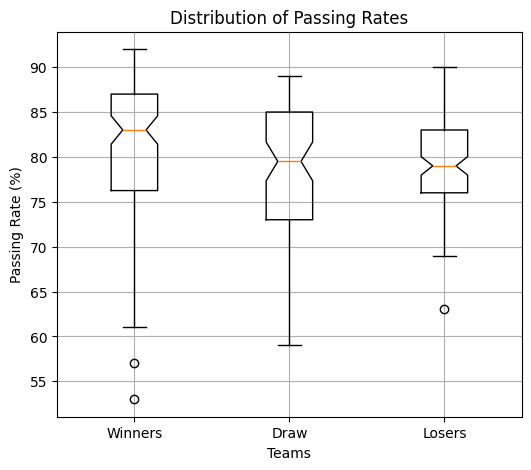

In [20]:
plt.figure(figsize=(6, 5))
plt.boxplot([df_winner['passing_quote'], df_draw['passing_quote'], df_loser['passing_quote']], labels=['Winners', 'Draw', 'Losers'], notch=True)
plt.xlabel('Teams')
plt.ylabel('Passing Rate (%)')
plt.title('Distribution of Passing Rates')
plt.grid(True)
plt.show()

#### Histogram

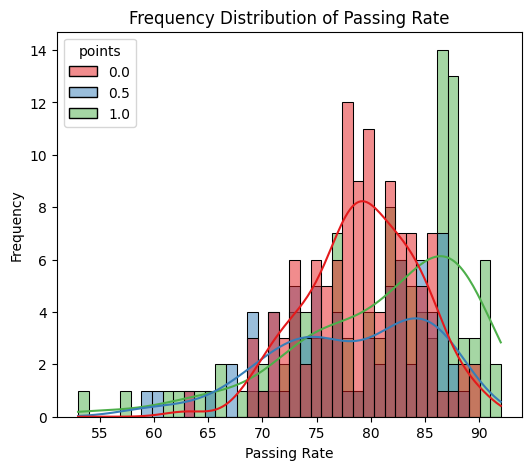

In [21]:
plt.figure(figsize=(6,5))
sns.histplot(data=game_data, x='passing_quote', hue='points', kde=True, bins=40, palette="Set1")
plt.title('Frequency Distribution of Passing Rate')
plt.xlabel('Passing Rate')
plt.ylabel('Frequency')
plt.show()